In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import warnings
warnings.filterwarnings('ignore')


In [19]:
df = pd.read_csv('data/preprocessed_data.csv', index_col=0, usecols=[0,8,9,12])

In [20]:
df.head()

,LT_EXH_TEMP,RT_EXH_TEMP,TURBO_INLET_PRESSURE
SS_TimeStamp,,,
2014-06-13 17:02:00,547,551,96.5
2014-06-13 17:02:00,545,549,96.5
2014-06-13 17:02:00,545,547,96.0
2014-06-14 11:00:00,550,557,96.5
2014-06-14 11:01:00,559,569,96.0


In [21]:
test_df = pd.read_csv('data/combined_testing_data.csv')

In [22]:
Test_dataframe = pd.read_csv('data/combined_testing_data.csv', parse_dates=['Observation Date (UTC-05:00)'], index_col='Observation Date (UTC-05:00)', usecols=[0,8,9,12])
Test_dataframe.sample(1)

,LT_EXH_TEMP (Lt Exh Temp(106)) Actual,RT_EXH_TEMP (Rt Exh Temp(108)) Actual,TURBO_INLET_PRESSURE (Trbo In Pres(101)) Actual
Observation Date (UTC-05:00),,,
2018-09-16 03:38:48,529,524,97.0


In [23]:
# Shape of both the datasets
df.shape,Test_dataframe.shape

((2928, 3), (96481, 3))

In [24]:
# normalize both the datasets
Test_dataframe.columns = df.columns
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_parameters=scaler.fit(df)
X_train = scaled_parameters.transform(df)
X_test = scaled_parameters.transform(Test_dataframe)

In [25]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (2928, 1, 3)
Test data shape: (96481, 1, 3)


In [26]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='linear', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = Dropout(0.2)(L1)
    L3 = LSTM(4, activation='sigmoid', return_sequences=False)(L1)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='sigmoid', return_sequences=True)(L4)
    L6 = Dropout(0.2)(L5)
    L7 = LSTM(16, activation='linear', return_sequences=True)(L5)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [27]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1280      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

In [28]:
# fit the model to the data
nb_epochs = 20
batch_size = 14
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/20
199/199 [==============================] - 7s 7ms/step - loss: 0.1520 - accuracy: 0.6663 - val_loss: 0.1131 - val_accuracy: 0.7007
Epoch 2/20
199/199 [==============================] - 1s 4ms/step - loss: 0.1213 - accuracy: 0.6663 - val_loss: 0.0959 - val_accuracy: 0.7007
Epoch 3/20
199/199 [==============================] - 1s 4ms/step - loss: 0.0877 - accuracy: 0.6444 - val_loss: 0.0529 - val_accuracy: 0.5850
Epoch 4/20
199/199 [==============================] - 1s 4ms/step - loss: 0.0540 - accuracy: 0.7141 - val_loss: 0.0327 - val_accuracy: 0.8571
Epoch 5/20
199/199 [==============================] - 1s 4ms/step - loss: 0.0404 - accuracy: 0.8317 - val_loss: 0.0242 - val_accuracy: 0.9048
Epoch 6/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0333 - accuracy: 0.8454 - val_loss: 0.0212 - val_accuracy: 0.9048
Epoch 7/20
199/199 [==============================] - 1s 5ms/step - loss: 0.0294 - accuracy: 0.8497 - val_loss: 0.0194 - val_accuracy: 0.9184
Epoch 

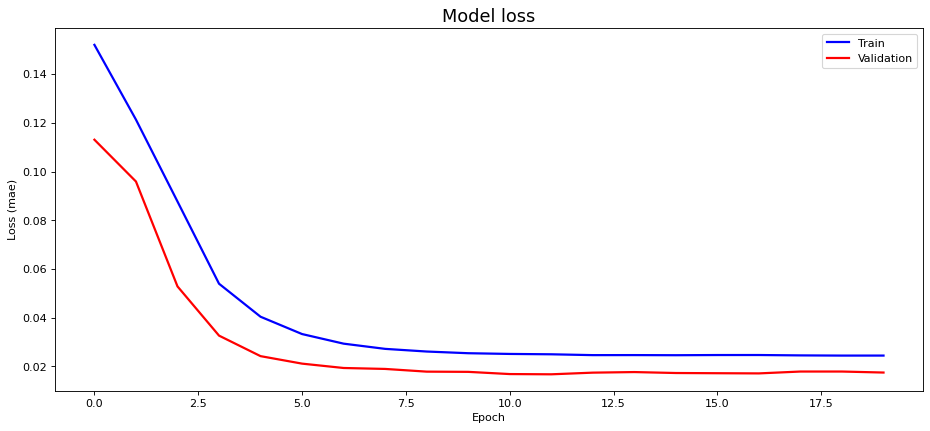

In [29]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [30]:
# Predictions using the model on the testing data and reshape the predictions so that inverse_transform could be performed on it
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

3016/3016 [==============================] - 6s 2ms/step


In [31]:
# Inverse_transform on the predicted values and the actual values
X_pred1 = scaler.inverse_transform(X_pred)
X_test = scaler.inverse_transform(X_test)

In [32]:
X_test.shape, X_pred1.shape

((96481, 3), (96481, 3))

In [33]:
# Residual i.e (Actual values - Predicted values)
resid=X_test[:]-X_pred1 [:]

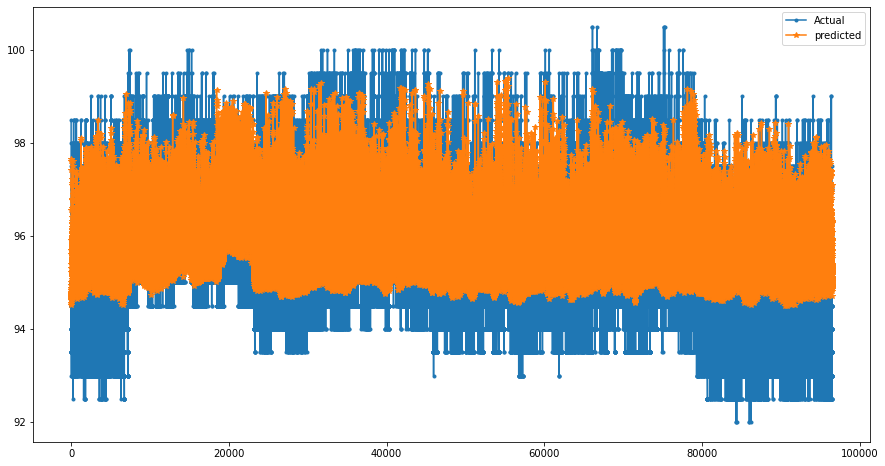

In [34]:
# Visualisation through line graph on one of the feature of data
# Actual values are in blue and Predicted values are in orange
plt.figure(figsize=[15,8])
plt.plot(X_test[:,2],label="Actual",marker=".")
plt.plot(X_pred1[:,2],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()

# It can be clearly seen that the values are bounded with respect to the training data and thus resulting in accurate predictions.

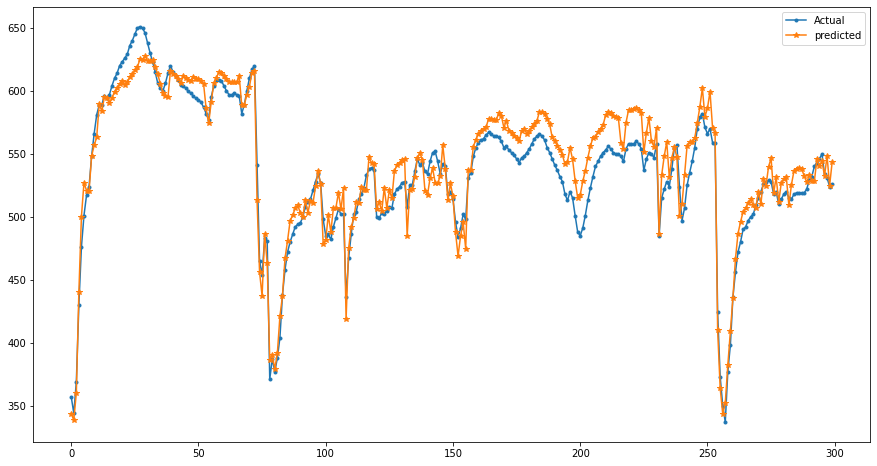

In [35]:
# A part of the whole data set for proper understanding
plt.figure(figsize=[15,8])
plt.plot(X_test[:300,0],label="Actual",marker=".")
plt.plot(X_pred1[:300,0],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()